In [195]:
# Installing Spark 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
!tar xf spark-3.3.0-bin-hadoop2.tgz
!pip install -q findspark

In [196]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop2"
from google.colab import drive
drive.mount('/content/drive')
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
#Getting Datatypes form Spark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, NullType, DoubleType, BooleanType
from pyspark.sql.functions import udf

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import re

In [198]:
#Setting up Schema 
schema = StructType([
                     StructField("Address", StringType(), False),
                     StructField("Lot", StringType(), True),
                     StructField("AM_or_PM", StringType(), True),
                     StructField("Browser Info", StringType(), True),
                     StructField("Company", StringType(),True),
                     StructField("Credit Card", StringType(), True),
                     StructField("CC Exp Date", StringType(), True),
                     StructField("CC Security Code", IntegerType(), True),
                     StructField("CC Provider", StringType(), True),
                     StructField("Email",StringType(), True),
                     StructField("Job", StringType(), True),
                     StructField("IP Address",StringType(), True),
                     StructField("Language",StringType(), True),
                     StructField("Purchase Price",DoubleType(), True)
                     
])

In [199]:
#Loading in data into spark dataframe 
df = spark.read.csv('/content/drive//MyDrive/code/Data_Set/Ecommerce_purchases.csv', 
                    schema = schema, header = True, multiLine = True)

In [200]:
#1.Show the first 10
df.show(10)

+--------------------+-----+--------+--------------------+--------------------+----------------+-----------+----------------+--------------------+--------------------+--------------------+---------------+--------+--------------+
|             Address|  Lot|AM_or_PM|        Browser Info|             Company|     Credit Card|CC Exp Date|CC Security Code|         CC Provider|               Email|                 Job|     IP Address|Language|Purchase Price|
+--------------------+-----+--------+--------------------+--------------------+----------------+-----------+----------------+--------------------+--------------------+--------------------+---------------+--------+--------------+
|16629 Pace Camp A...|46 in|      PM|Opera/9.56.(X11; ...|     Martinez-Herman|6011929061123406|      02/20|             900|        JCB 16 digit|   pdunlap@yahoo.com|Scientist, produc...|149.146.147.205|      el|         98.14|
|9374 Jasmine Spur...|28 rn|      PM|Opera/8.93.(Windo...|Fletcher, Richard...|33377

In [201]:
#2.Show last 10, no real easy what to to do this nicely 
last_10 = spark.sparkContext.parallelize(df.tail(10))
last_10 = spark.createDataFrame(last_10, schema)
last_10.show()

+--------------------+-----+--------+--------------------+--------------------+----------------+-----------+----------------+----------------+--------------------+--------------------+---------------+--------+--------------+
|             Address|  Lot|AM_or_PM|        Browser Info|             Company|     Credit Card|CC Exp Date|CC Security Code|     CC Provider|               Email|                 Job|     IP Address|Language|Purchase Price|
+--------------------+-----+--------+--------------------+--------------------+----------------+-----------+----------------+----------------+--------------------+--------------------+---------------+--------+--------------+
|75731 Molly Sprin...|93 ty|      PM|Mozilla/5.0 (Maci...|Pace, Vazquez and...| 869968197049750|      04/24|             877|    JCB 15 digit|andersonmichael@s...| Early years teacher|   54.170.3.185|      ru|         18.35|
|PSC 8165, Box 849...|50 dA|      AM|Mozilla/5.0 (comp...|          Snyder Inc|4221582137197481|    

In [202]:
#3.Check DataType Columns
df.printSchema()

root
 |-- Address: string (nullable = true)
 |-- Lot: string (nullable = true)
 |-- AM_or_PM: string (nullable = true)
 |-- Browser Info: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Credit Card: string (nullable = true)
 |-- CC Exp Date: string (nullable = true)
 |-- CC Security Code: integer (nullable = true)
 |-- CC Provider: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Job: string (nullable = true)
 |-- IP Address: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Purchase Price: double (nullable = true)



In [203]:
#4. Check null values in the data set
#a. When we write isnull() method it creates boolean table
pd_df = df.pandas_api()
print(type(pd_df)) 
pd_df.isnull().head(10)

<class 'pyspark.pandas.frame.DataFrame'>


Address    Lot  AM_or_PM  Browser Info  Company  Credit Card  CC Exp Date  CC Security Code  CC Provider  Email    Job  IP Address  Language  Purchase Price
0    False  False     False         False    False        False        False             False        False  False  False       False     False           False
1    False  False     False         False    False        False        False             False        False  False  False       False     False           False
2    False  False     False         False    False        False        False             False        False  False  False       False     False           False
3    False  False     False         False    False        False        False             False        False  False  False       False     False           False
4    False  False     False         False    False        False        False             False        False  False  False       False     False           False
5    False  False     False         False    False        False        False             False        False  False  False       False     False           False
6    False  False     False         False    False        False        False             False        False  False  False       False     False           False
7    False  False     False         False    False        False        False             False        False  False  False       False     False           False
8    False  False     False         False    False        False        False             False        False  False  False       False     False           False
9    False  False     False         False    False        False        False             False        False  False  False       False     False           False

In [204]:
#b.now you have to count that is there any missing value in the 
#dataset or not ?
pd_df.isnull().sum()

Address             0
Lot                 0
AM_or_PM            0
Browser Info        0
Company             0
Credit Card         0
CC Exp Date         0
CC Security Code    0
CC Provider         0
Email               0
Job                 0
IP Address          0
Language            0
Purchase Price      0
dtype: int64

In [205]:
#5. How many rows and columns are there in our Dataset?
pd_df.shape

(10000, 14)

In [206]:
#6. Show all columns first then find the length of them.
print(pd_df.columns)
print('Length:', len(pd_df.columns))

Index(['Address', 'Lot', 'AM_or_PM', 'Browser Info', 'Company', 'Credit Card',
       'CC Exp Date', 'CC Security Code', 'CC Provider', 'Email', 'Job',
       'IP Address', 'Language', 'Purchase Price'],
      dtype='object')
Length: 14


In [207]:
#7. Show all number of rows
pd_df

Address    Lot AM_or_PM                                                                                                                                        Browser Info                           Company       Credit Card CC Exp Date  CC Security Code                  CC Provider                                      Email                                                          Job       IP Address Language  Purchase Price
0              16629 Pace Camp Apt. 448\nAlexisborough, NE 77130-7478  46 in       PM                                                                                  Opera/9.56.(X11; Linux x86_64; sl-SI) Presto/2.9.183 Version/12.00                   Martinez-Herman  6011929061123406       02/20               900                 JCB 16 digit                          pdunlap@yahoo.com                       Scientist, product/process development  149.146.147.205       el           98.14
1             9374 Jasmine Spurs Suite 508\nSouth John, TN 84355-4179  28 rn       PM                                                                            Opera/8.93.(Windows 98; Win 9x 4.90; en-US) Presto/2.9.176 Version/11.00   Fletcher, Richards and Whitaker  3337758169645356       11/18               561                   Mastercard                         anthony41@reed.com                                            Drilling engineer     15.160.41.51       fr           70.73
2                                    Unit 0065 Box 5052\nDPO AP 27450  94 vE       PM                                                                                     Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; Trident/5.1)        Simpson, Williams and Pham      675957666125       08/19               699                 JCB 16 digit             amymiller@morales-harrison.com                                     Customer service manager   132.207.160.22       de            0.95
3                               7780 Julia Fords\nNew Stacy, WA 45798  36 vm       PM                   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0 rv:3.0; en-US) AppleWebKit/531.27.1 (KHTML, like Gecko) Version/5.1 Safari/531.27.1   Williams, Marshall and Buchanan  6011578504430710       02/24               384                     Discover                brent16@olson-robinson.info                                            Drilling engineer     30.250.74.19       es           78.04
4                  23012 Munoz Drive Suite 337\nNew Cynthia, TX 57826  20 IE       AM                                                                                  Opera/9.58.(X11; Linux x86_64; it-IT) Presto/2.9.182 Version/11.00         Brown, Watson and Andrews  6011456623207998       10/25               678  Diners Club / Carte Blanche                christopherwright@gmail.com                                                  Fine artist     24.140.33.94       es           77.82
5             7502 Powell Mission Apt. 768\nTravisland, VA 30493-5334  21 XT       PM                                  Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_8_5) AppleWebKit/5312 (KHTML, like Gecko) Chrome/14.0.884.0 Safari/5312                    Silva-Anderson    30246185196287       07/25              7169                     Discover                          ynguyen@gmail.com                                            Fish farm manager    55.96.152.147       ru           25.15
6                      93971 Conway Causeway\nAndersonburgh, AZ 75107  96 Xt       AM                                                                                     Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 5.0; Trident/3.0)                   Gibson and Sons  6011398782655569       07/24               714                VISA 16 digit                         olivia04@yahoo.com                                                       Dancer   127.252.144.18       de           88.56
7              260 Rachel Plains Suite 366\nCastroberg, WV 24804-9384  96 pG       PM                                                 

In [208]:
#8. Show complete information of dataset.
print(pd_df.info())
print(pd_df.describe()['Purchase Price'])

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Address           10000 non-null  object 
 1   Lot               10000 non-null  object 
 2   AM_or_PM          10000 non-null  object 
 3   Browser Info      10000 non-null  object 
 4   Company           10000 non-null  object 
 5   Credit Card       10000 non-null  object 
 6   CC Exp Date       10000 non-null  object 
 7   CC Security Code  10000 non-null  int32  
 8   CC Provider       10000 non-null  object 
 9   Email             10000 non-null  object 
 10  Job               10000 non-null  object 
 11  IP Address        10000 non-null  object 
 12  Language          10000 non-null  object 
 13  Purchase Price    10000 non-null  float64
dtypes: float64(1), int32(1), object(12)None
count    10000.000000
mean        50.347302
std         29.015836
min          0.000000
25% 

In [209]:
#9. Show Highest and Lowest Purchase Prices.
print(pd_df.nlargest(1, columns='Purchase Price').to_markdown())
print(pd_df.nsmallest(1, columns='Purchase Price').to_markdown())

|      | Address              | Lot   | AM_or_PM   | Browser Info                                                                                       | Company     |   Credit Card | CC Exp Date   |   CC Security Code | CC Provider   | Email                    | Job                    | IP Address      | Language   |   Purchase Price |
|-----:|:---------------------|:------|:-----------|:---------------------------------------------------------------------------------------------------|:------------|--------------:|:--------------|-------------------:|:--------------|:-------------------------|:-----------------------|:----------------|:-----------|-----------------:|
| 2092 | 63773 Shelton Greens | 56 lu | AM         | Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5352 (KHTML, like Gecko) Chrome/13.0.806.0 Safari/5352 | Pitts Group | 4292741269160 | 06/18         |                824 | Maestro       | heatherwoodard@lloyd.com | Surveyor, hydrographic | 172.197.216.229 | el         |   

In [210]:
#10. Show average purchase price
pd_df.mean(axis=0, numeric_only=True)['Purchase Price']

50.34730200000025

In [211]:
# 11. How many people have French 'fr' as their Language?
# a. First show all columns then all languages
print(pd_df.columns.to_list())
print(pd_df.groupby('Language').nunique().index.to_list())
# b. Check whether 'fr' is there or not
if 'fr' not in pd_df.groupby('Language').nunique().index.to_list():
  print('No French purchase.')
# c. Compare language to 'fr'
pd_df.groupby('Language').nunique()[["Credit Card", 'Purchase Price']]

['Address', 'Lot', 'AM_or_PM', 'Browser Info', 'Company', 'Credit Card', 'CC Exp Date', 'CC Security Code', 'CC Provider', 'Email', 'Job', 'IP Address', 'Language', 'Purchase Price']
['en', 'pt', 'de', 'es', 'el', 'it', 'ru', 'zh', 'fr']


Credit Card  Purchase Price
Language                             
en               1098            1047
pt               1118            1053
de               1155            1082
es               1095            1054
el               1137            1077
it               1086            1034
ru               1155            1094
zh               1059            1009
fr               1097            1050

In [212]:
# 12. Find Job Title Contains Engineer word
# a. Show all columns then look for 'Job' match it with 'engineer'
print(pd_df.columns.to_list())

['Address', 'Lot', 'AM_or_PM', 'Browser Info', 'Company', 'Credit Card', 'CC Exp Date', 'CC Security Code', 'CC Provider', 'Email', 'Job', 'IP Address', 'Language', 'Purchase Price']


In [213]:
# b. Show all result rows having that word
no_cap_eng = pd_df[pd_df['Job'].str.contains('engineer')]
no_cap_eng

Address    Lot AM_or_PM                                                                                                                                        Browser Info                          Company       Credit Card CC Exp Date  CC Security Code                  CC Provider                                        Email                                   Job       IP Address Language  Purchase Price
1                   9374 Jasmine Spurs Suite 508\nSouth John, TN 84355-4179  28 rn       PM                                                                            Opera/8.93.(Windows 98; Win 9x 4.90; en-US) Presto/2.9.176 Version/11.00  Fletcher, Richards and Whitaker  3337758169645356       11/18               561                   Mastercard                           anthony41@reed.com                     Drilling engineer     15.160.41.51       fr           70.73
3                                     7780 Julia Fords\nNew Stacy, WA 45798  36 vm       PM                   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0 rv:3.0; en-US) AppleWebKit/531.27.1 (KHTML, like Gecko) Version/5.1 Safari/531.27.1  Williams, Marshall and Buchanan  6011578504430710       02/24               384                     Discover                  brent16@olson-robinson.info                     Drilling engineer     30.250.74.19       es           78.04
50                          41159 Michael Centers\nAdamsfort, RI 37108-6674  46 Ce       PM                                                     Mozilla/5.0 (Windows 98; Win 9x 4.90; sl-SI; rv:1.9.2.20) Gecko/2016-05-03 02:05:14 Firefox/3.8      Wright, Williams and Mendez  4008586485908075       05/19               945                 JCB 16 digit                    susanvalentine@obrien.org                   Mechanical engineer  213.203.143.215       de           36.85
103                                    480 Ronald Cape\nJohnville, MA 53644  11 wg       AM                                Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5_9) AppleWebKit/5342 (KHTML, like Gecko) Chrome/13.0.881.0 Safari/5342                        Brown Inc    30276609779632       03/22               676                     Discover                wtownsend@jackson-johnson.biz              Technical sales engineer   119.178.136.56       it           51.37
193          1010 Mahoney Mills Suite 486\nWest Danielleview, NH 07516-2814  70 Fd       AM                                                                 Mozilla/5.0 (X11; Linux i686; rv:1.9.5.20) Gecko/2010-05-29 11:43:46 Firefox/3.6.17                    Wilson-Dennis    30359256148796       02/22                62                 JCB 16 digit                             stacy72@cruz.com                       Energy engineer   189.183.41.220       pt           96.79
200                                               USCGC Grant\nFPO AA 10424  97 qN       PM                                                                    Mozilla/5.0 (X11; Linux i686; rv:1.9.6.20) Gecko/2015-12-21 14:16:20 Firefox/3.8                      Barrett LLC  3096521249347703       10/21               155                      Voyager                     danielsmith@delacruz.biz                        Water engineer   132.254.220.76       ru           22.37
202                      24079 Kelly Crest Apt. 260\nMayerborough, MH 98098  09 rQ       PM                                            Mozilla/5.0 (Windows 98; Win 9x 4.90) AppleWebKit/5330 (KHTML, like Gecko) Chrome/15.0.892.0 Safari/5330                   Valenzuela PLC  5549558244757443       10/21               539                     Discover                           thomas52@yahoo.com                     Software engineer   216.179.195.90       es           99.28
246                           666 Davis Junction\nEast Destinyton, IL 88122  50 WE       PM    Mozilla/5.0 (iPod; U; CPU iPhone OS 4_1 like Mac OS X; en-US) AppleWebKit/533.6.6 (KHTML, like Gecko) Version/4.0.5 Mobile/8B113 Safari/6533.6.6           Jacobs, Patel and 

In [214]:
# c. Now make your search as case insensitive
cap_eng = pd_df[pd_df['Job'].str.contains('engineer', flags = re.IGNORECASE)]
cap_eng

Address    Lot AM_or_PM                                                                                                                                        Browser Info                            Company       Credit Card CC Exp Date  CC Security Code                  CC Provider                                        Email                                    Job       IP Address Language  Purchase Price
1                   9374 Jasmine Spurs Suite 508\nSouth John, TN 84355-4179  28 rn       PM                                                                            Opera/8.93.(Windows 98; Win 9x 4.90; en-US) Presto/2.9.176 Version/11.00    Fletcher, Richards and Whitaker  3337758169645356       11/18               561                   Mastercard                           anthony41@reed.com                      Drilling engineer     15.160.41.51       fr           70.73
3                                     7780 Julia Fords\nNew Stacy, WA 45798  36 vm       PM                   Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0 rv:3.0; en-US) AppleWebKit/531.27.1 (KHTML, like Gecko) Version/5.1 Safari/531.27.1    Williams, Marshall and Buchanan  6011578504430710       02/24               384                     Discover                  brent16@olson-robinson.info                      Drilling engineer     30.250.74.19       es           78.04
50                          41159 Michael Centers\nAdamsfort, RI 37108-6674  46 Ce       PM                                                     Mozilla/5.0 (Windows 98; Win 9x 4.90; sl-SI; rv:1.9.2.20) Gecko/2016-05-03 02:05:14 Firefox/3.8        Wright, Williams and Mendez  4008586485908075       05/19               945                 JCB 16 digit                    susanvalentine@obrien.org                    Mechanical engineer  213.203.143.215       de           36.85
55                 27635 Maureen Bypass Apt. 883\nSandraview, SD 92835-3333  59 LJ       AM  Mozilla/5.0 (iPod; U; CPU iPhone OS 3_3 like Mac OS X; en-US) AppleWebKit/534.33.7 (KHTML, like Gecko) Version/4.0.5 Mobile/8B113 Safari/6534.33.7                         Sims-Lyons  3158113629128344       09/19               857                VISA 16 digit                       adkinsarthur@yahoo.com    Engineer, broadcasting (operations)   227.235.89.210       pt           48.74
60                       7126 Katherine Squares\nPerkinsview, CO 97299-0900  63 qu       AM                                                                                  Opera/8.68.(X11; Linux x86_64; en-US) Presto/2.9.160 Version/12.00                 Marshall-Fernandez   349767747049645       05/20               672                 JCB 15 digit                      sweeneyhannah@jones.biz                 Engineer, agricultural  197.144.142.102       de           20.43
64                    937 Weaver Isle Apt. 096\nTracyborough, KY 18263-4998  97 QO       AM                     Mozilla/5.0 (Macintosh; PPC Mac OS X 10_6_2 rv:3.0; it-IT) AppleWebKit/534.40.7 (KHTML, like Gecko) Version/4.0 Safari/534.40.7                          Villa Inc   869930676434762       11/21               578                     Discover                 jason24@gardner-anderson.com           Engineer, civil (consulting)    218.171.210.9       it           72.45
82            493 Smith Valleys Suite 004\nNew Madelineville, NV 59414-0344  35 ls       PM  Mozilla/5.0 (iPod; U; CPU iPhone OS 4_0 like Mac OS X; it-IT) AppleWebKit/532.13.7 (KHTML, like Gecko) Version/4.0.5 Mobile/8B115 Safari/6532.13.7      Robinson, Johnston and Valdez  4351359627548412       06/17               937                VISA 13 digit                            amendez@yahoo.com                    Engineer, materials  163.129.163.100       fr           49.04
92                                    Unit 9659 Box 0618\nDPO AA 00377-5360  37 jN       AM                                                                                     Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.0; Trident/3.0)     

In [215]:
# d. Find the length of resulting data too
print('Shape of engineer (case sensitive):', no_cap_eng.shape)
print('Shape of engineer (case insensitive):', cap_eng.shape)

Shape of engineer (case sensitive): (531, 14)
Shape of engineer (case insensitive): (984, 14)


In [216]:
# 13. Find The Email of the person with the following IP Address: 132.207.160.22
# a. First display all column to know on which column you have to work
print(pd_df.columns.to_list())

['Address', 'Lot', 'AM_or_PM', 'Browser Info', 'Company', 'Credit Card', 'CC Exp Date', 'CC Security Code', 'CC Provider', 'Email', 'Job', 'IP Address', 'Language', 'Purchase Price']


In [217]:
# b. Compare the column to ip address and show the results
pd_df[['Email', 'IP Address']]

Email       IP Address
0                            pdunlap@yahoo.com  149.146.147.205
1                           anthony41@reed.com     15.160.41.51
2               amymiller@morales-harrison.com   132.207.160.22
3                  brent16@olson-robinson.info     30.250.74.19
4                  christopherwright@gmail.com     24.140.33.94
5                            ynguyen@gmail.com    55.96.152.147
6                           olivia04@yahoo.com   127.252.144.18
7                         phillip48@parks.info   224.247.97.150
8                         kdavis@rasmussen.com  146.234.201.229
9                     qcoleman@hunt-huerta.com    236.198.199.8
10                        ustewart@hotmail.com       26.59.93.1
11                    johnnymiller@coleman.com   128.222.40.234
12                           tholt@hotmail.com   236.71.234.240
13                         caitlin57@yahoo.com     84.212.92.11
14                            aburns@yahoo.com      50.25.148.1
15                          amanda39@yahoo.com    53.176.235.33
16                 griffincatherine@wilson.com     8.145.170.52
17                      stacymitchell@hall.com    223.25.125.61
18                          hannah63@yahoo.com   73.250.176.201
19                        ruiznicole@gmail.com   25.105.209.214
20                      zstephenson@smith.info    250.71.54.180
21                          rsmith@hotmail.com    125.58.66.253
22                   chambersmichael@gmail.com    65.106.61.141
23                 ltaylor@gardner-meadows.com   25.193.145.116
24                           james07@yahoo.com   21.113.231.220
25                        madison41@mooney.com    67.26.186.226
26                            mlogan@gmail.com   61.197.134.185
27                       michael35@hotmail.com   177.220.131.93
28                       khandeborah@yahoo.com  142.131.235.225
29                        stonekaren@yahoo.com  218.189.145.248
30                       laurahess@hotmail.com   215.63.180.154
31                        ashley12@hotmail.com   94.176.142.201
32                        shane21@atkinson.com   196.37.134.217
33                   salazarpatricia@yahoo.com   187.206.154.93
34                      mdavis@carey-davis.com    46.198.92.108
35                      hgonzalez@mcdowell.com     216.23.95.40
36                    saundersernest@walsh.com    85.134.58.250
37                       marc20@frederick.info   17.202.105.185
38                  djennings@boyd-english.org   143.138.65.219
39              stephanie90@wells-carlson.info     47.93.149.75
40               hernandezevelyn@dickerson.com  102.225.220.122
41                    kimberlygaines@yahoo.com  246.108.171.137
42                            cwalsh@gmail.com    50.235.90.141
43          phillipallison@martinez-thomas.com      242.88.41.9
44                          aprilorr@yahoo.com   95.100.249.114
45                  gregorygarner@chambers.com    222.242.66.78
46                         wmckenzie@gmail.com      38.56.10.36
47                            zrocha@glenn.org   84.195.175.153
48                        pruittjohn@allen.com     13.159.43.73
49                      schmidtjacob@gmail.com    84.240.35.144
50                   susanvalentine@obrien.org  213.203.143.215
51           vincentgriffith@cook-castillo.com  142.171.212.118
52                     greenjulian@hotmail.com    5.126.206.189
53                          amorales@yahoo.com   44.108.117.122
54                  stewartwilliam@hotmail.com    154.150.83.22
55                      adkinsarthur@yahoo.com   227.235.89.210
56                albert68@lawrence-warren.biz     100.59.92.18
57                        timothy88@morris.com   135.11.140.254
58                             udavis@howe.com      77.68.59.64
59                    lindseyturner@walton.org  139.242.244.155
60                     sweeneyhannah@jones.biz  197.144.142.102
61                        diazronald@gmail.com     76.32.252.85
62       

In [218]:
# c. Now display email only of that IP address 
pd_df.loc[pd_df['IP Address'] == '132.207.160.22']['Email']

2    amymiller@morales-harrison.com
Name: Email, dtype: object

In [219]:
# 14. How many People have Mastercard as their Credit Card Provider and made a purchase
# above 50 dollars?
# a. First display columns
print(pd_df.columns.to_list())
# b. Do some comparisons and show numbers
pd_df.loc[(pd_df['CC Provider'] == 'Mastercard') & (pd_df['Purchase Price'] > 50)].shape[0]

['Address', 'Lot', 'AM_or_PM', 'Browser Info', 'Company', 'Credit Card', 'CC Exp Date', 'CC Security Code', 'CC Provider', 'Email', 'Job', 'IP Address', 'Language', 'Purchase Price']


405

In [220]:
#15. Find the email of the person with the following Credit Card Number: 4664825258997302
pd_df.loc[pd_df['Credit Card'] == '4664825258997302']['Email']

9992    bberry@wright.net
Name: Email, dtype: object

In [221]:
#16. How many people purchase during the AM and how many people purchase during PM?
pd_df.groupby('AM_or_PM').count()['Purchase Price']

AM_or_PM
PM    5068
AM    4932
Name: Purchase Price, dtype: int64

In [222]:
# 17. How many people have a credit card that expires in 2020?
# a. Show columns first
print(pd_df.columns.to_list())

['Address', 'Lot', 'AM_or_PM', 'Browser Info', 'Company', 'Credit Card', 'CC Exp Date', 'CC Security Code', 'CC Provider', 'Email', 'Job', 'IP Address', 'Language', 'Purchase Price']


In [223]:
# b. Check the format of date
for i in pd_df['CC Exp Date'].str.split('/').to_list():
  if int(i[0]) >= 13 or int(i[0]) <=0:
    print('Not in MM/YY')

In [224]:
# c. Create a user defined function which counts how many persons having credit card
# expired in 2020
@udf(BooleanType())
def expire(date):
    i = date.split('/')
    print(date)
    if i[1] == '20':
      return True 
    else:
      return False

df.withColumn('2020 Expire', expire(df['CC Exp Date'])).show()


+--------------------+-----+--------+--------------------+--------------------+----------------+-----------+----------------+--------------------+--------------------+--------------------+---------------+--------+--------------+-----------+
|             Address|  Lot|AM_or_PM|        Browser Info|             Company|     Credit Card|CC Exp Date|CC Security Code|         CC Provider|               Email|                 Job|     IP Address|Language|Purchase Price|2020 Expire|
+--------------------+-----+--------+--------------------+--------------------+----------------+-----------+----------------+--------------------+--------------------+--------------------+---------------+--------+--------------+-----------+
|16629 Pace Camp A...|46 in|      PM|Opera/9.56.(X11; ...|     Martinez-Herman|6011929061123406|      02/20|             900|        JCB 16 digit|   pdunlap@yahoo.com|Scientist, produc...|149.146.147.205|      el|         98.14|       true|
|9374 Jasmine Spur...|28 rn|      PM

In [225]:
df.withColumn('2020 Expire', expire(df['CC Exp Date'])).groupby('2020 Expire').count().show()

+-----------+-----+
|2020 Expire|count|
+-----------+-----+
|       true|  988|
|      false| 9012|
+-----------+-----+



In [226]:
#18. What are the top 5 most popular email providers (e.g. Gmail.com, yahoo.com, etc...)
# a. Create either user defined function or use your own any other way for getting the
# result.
#Decorator for returning the tpe back to the df 
@udf(StringType())
def email_split(date):
    i = date.split('@')
    return i[1]

email_df = df.withColumn('Email Providers', email_split(df['Email']))[['Email','Email Providers',]]
email_df = email_df.groupby('Email Providers').count()
email_df = email_df.orderBy('count', ascending = False)
email_df.show(5)

+---------------+-----+
|Email Providers|count|
+---------------+-----+
|    hotmail.com| 1638|
|      yahoo.com| 1616|
|      gmail.com| 1605|
|      smith.com|   42|
|   williams.com|   37|
+---------------+-----+
only showing top 5 rows



#Extra

Email Providers  count  Precentage
0     hotmail.com   1638       16.38
1       yahoo.com   1616       16.16
2       gmail.com   1605       16.05
3       smith.com     42        0.42
0           Other   5099       50.99

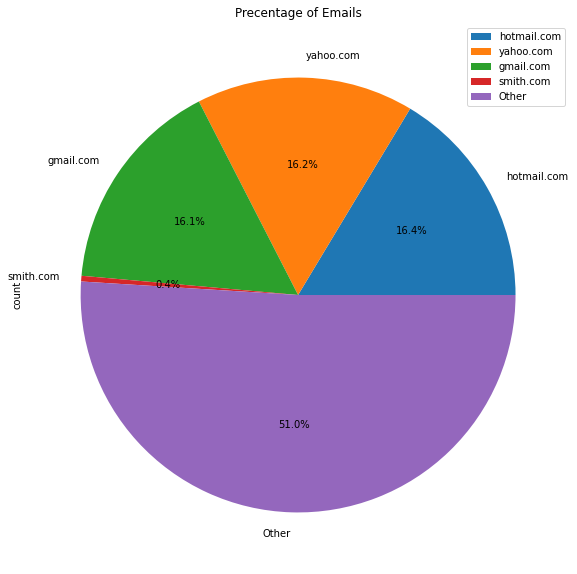

In [227]:
#get the top 4 emails 
email_top = email_df.pandas_api().head(4)
#get all other 
email_rest = email_df.pandas_api().loc[4:]
#sum all other emails totals 
#make a temp data frame to easily append
temp = spark.createDataFrame([{'Email Providers':'Other', 'count':email_rest['count'].sum()}])
#Convert to spark.pandas.dataframe, add append 
emails = email_top.append(temp.pandas_api()) 
#graph 
emails.to_pandas().set_index('Email Providers')\
          .plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), title = "Precentage of Emails")
#show table with calculated %
emails['Precentage'] = emails['count']/emails['count'].sum() * 100
emails

The Pie Chart above shows the top ten precentages of emails used in the data set with lesser used grouped in 'Other'. 

In [228]:
#Get the year that the card expires 
@udf(StringType())
def expire_year(date):
    i = date.split('/')
    return i[1]
df = df.withColumn('Expire Year', expire_year(df['CC Exp Date']))

In [245]:
#get the browser used 
@udf(StringType())
def get_browser(browser_info):
    if 'chrome' in browser_info.lower() :
      return 'Chrome'
    if 'presto' in browser_info.lower():
      return 'Presto'
    if 'safari' in browser_info.lower():
      return 'Safari'
    if 'trident' in browser_info.lower():
      return 'Trident'
    if 'firefox' in browser_info.lower():
      return 'Firefox'
    return 'Not known'
    
df = df.withColumn('Browsers', get_browser(df['Browser Info']))

In [229]:
#get the os of the system used 
@udf(StringType())
def get_company_os(browser_info):
    if 'apple' in browser_info.lower() or 'mac' in browser_info.lower():
      return 'Apple'
    if 'windows' in browser_info.lower():
      return 'Microsoft'
    if 'linux' in browser_info.lower():
      return 'Linux'
    return 'Not known'
    
df = df.withColumn('Company OS', get_company_os(df['Browser Info']))

In [246]:
pd_df = df.pandas_api().to_pandas()
pd_df

Address    Lot AM_or_PM  \
0     16629 Pace Camp Apt. 448\nAlexisborough, NE 77...  46 in       PM   
1     9374 Jasmine Spurs Suite 508\nSouth John, TN 8...  28 rn       PM   
2                      Unit 0065 Box 5052\nDPO AP 27450  94 vE       PM   
3                 7780 Julia Fords\nNew Stacy, WA 45798  36 vm       PM   
4     23012 Munoz Drive Suite 337\nNew Cynthia, TX 5...  20 IE       AM   
...                                                 ...    ...      ...   
9995      966 Castaneda Locks\nWest Juliafurt, CO 96415  92 XI       PM   
9996  832 Curtis Dam Suite 785\nNorth Edwardburgh, T...  41 JY       AM   
9997              Unit 4434 Box 6343\nDPO AE 28026-0283  74 Zh       AM   
9998               0096 English Rest\nRoystad, IA 12457  74 cL       PM   
9999     40674 Barrett Stravenue\nGrimesville, WI 79682  64 Hr       AM   

                                           Browser Info  \
0     Opera/9.56.(X11; Linux x86_64; sl-SI) Presto/2...   
1     Opera/8.93.(Windows 98; Win 9x 4.90; en-US) Pr...   
2     Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...   
3     Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0 ...   
4     Opera/9.58.(X11; Linux x86_64; it-IT) Presto/2...   
...                                                 ...   
9995  Mozilla/5.0 (Windows NT 5.1) AppleWebKit/5352 ...   
9996  Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...   
9997  Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_7...   
9998  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_8;...   
9999  Mozilla/5.0 (X11; Linux i686; rv:1.9.5.20) Gec...   

                              Company       Credit Card CC Exp Date  \
0                     Martinez-Herman  6011929061123406       02/20   
1     Fletcher, Richards and Whitaker  3337758169645356       11/18   
2          Simpson, Williams and Pham      675957666125       08/19   
3     Williams, Marshall and Buchanan  6011578504430710       02/24   
4           Brown, Watson and Andrews  6011456623207998       10/25   
...                               ...               ...         ...   
9995                    Randall-Sloan   342945015358701       03/22   
9996         Hale, Collins and Wilson   210033169205009       07/25   
9997                     Anderson Ltd  6011539787356311       05/21   
9998                         Cook Inc   180003348082930       11/17   
9999                       Greene Inc  4139972901927273       02/19   

      CC Security Code                  CC Provider  \
0                  900                 JCB 16 digit   
1                  561                   Mastercard   
2                  699                 JCB 16 digit   
3                  384                     Discover   
4                  678  Diners Club / Carte Blanche   
...                ...                          ...   
9995               838                 JCB 15 digit   
9996               207                 JCB 16 digit   
9997                 1                VISA 16 digit   
9998               987             American Express   
9999               302                 JCB 15 digit   

                               Email                                     Job  \
0                  pdunlap@yahoo.com  Scientist, product/process development   
1                 anthony41@reed.com                       Drilling engineer   
2     amymiller@morales-harrison.com                Customer service manager   
3        brent16@olson-robinson.info                       Drilling engineer   
4        christopherwright@gmail.com                             Fine artist   
...                              ...                                     ...   
9995          iscott@wade-garner.com                              Printmaker   
9996              mary85@hotmail.com                         Energy engineer   
9997               tyler16@gmail.com                      Veterinary surgeon   
9998         elizabethmoore@reid.net                Local government officer   
9999           rachelford@vaughn.com        

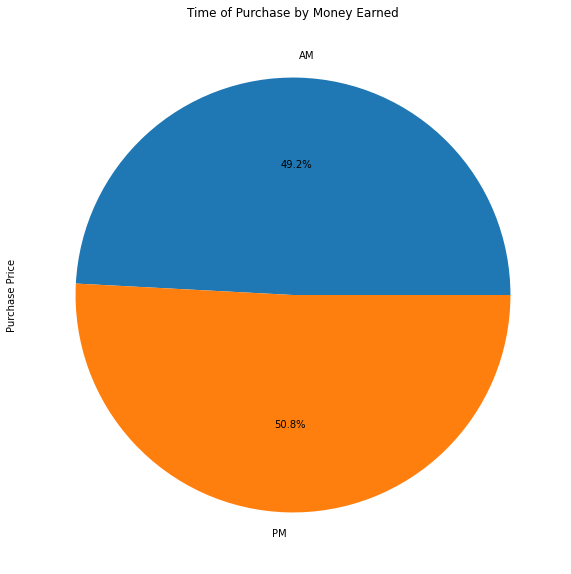

In [231]:
pd_df.groupby('AM_or_PM')['Purchase Price'].sum().plot(kind='pie', y='sum', autopct='%1.1f%%', figsize = (10,10), title = "Time of Purchase by Money Earned")

Pie Graph showing the precentage of buys during the AM and PM.

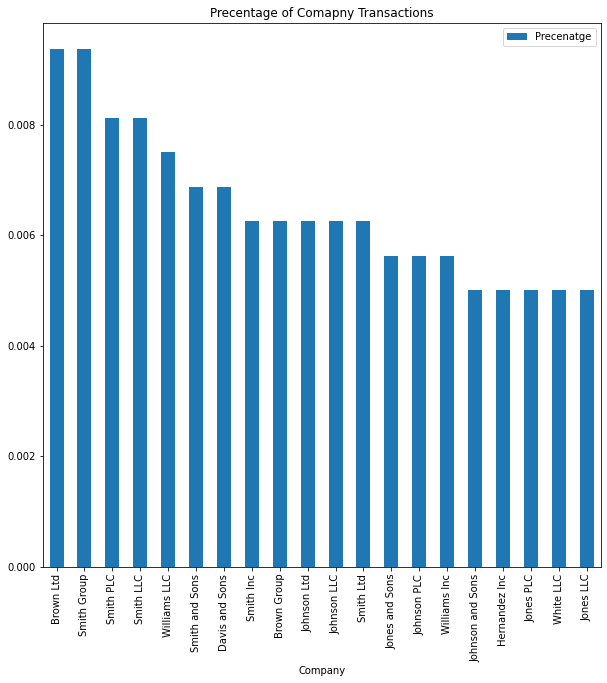

In [232]:
company = pd_df.groupby('Company')['Company'].count().sort_values(ascending=False).head(20)
#caluclate % of purchases 
company_values=company.values/pd_df.size*100
#Convert to dataframe then, graph 
pd.DataFrame(company_values,company.index).rename(columns={0: 'Precenatge'})\
  .plot.bar( figsize = (10,10), title = "Precentage of Comapny Transactions")

Precentage of frequency of purchases per company. Top 20.

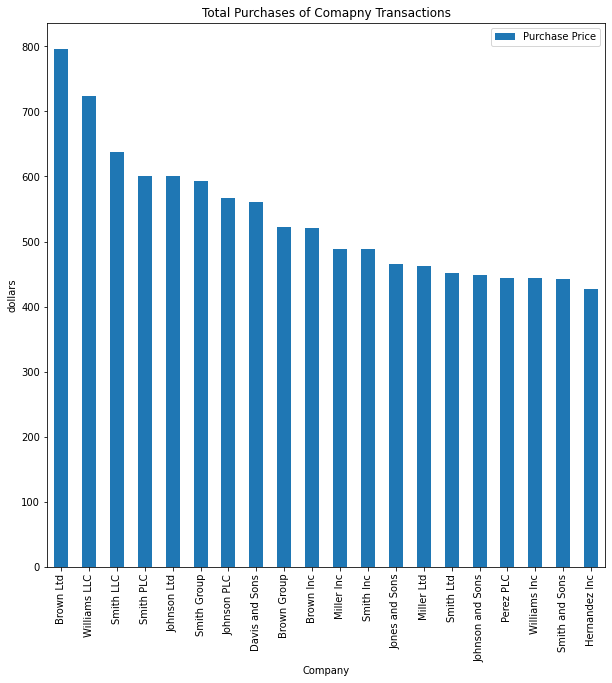

In [233]:
#get the total purchases sum per company 
company_expense = pd_df.groupby('Company')['Purchase Price'].sum().sort_values(ascending=False)
pd.DataFrame(company_expense.head(20)).plot.bar( figsize = (10,10), 
                             title = "Total Purchases of Comapny Transactions",
                             ylabel = "dollars")

Money spent per company. Top 20.

Notice Brown Ltd is spends the most and has the most transactions. Smith Group has the same precentage of Brrown Ltd, but spends less money. 

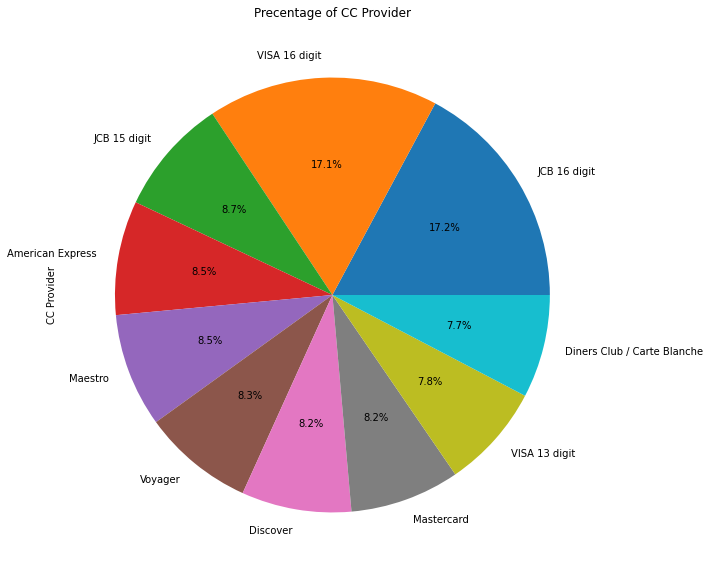

In [234]:
#% of CC Providers 
credit = pd_df.groupby('CC Provider')['CC Provider'].count().sort_values(ascending=False)
credit.plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), title = "Precentage of CC Provider")

Precentage of credit cards used.

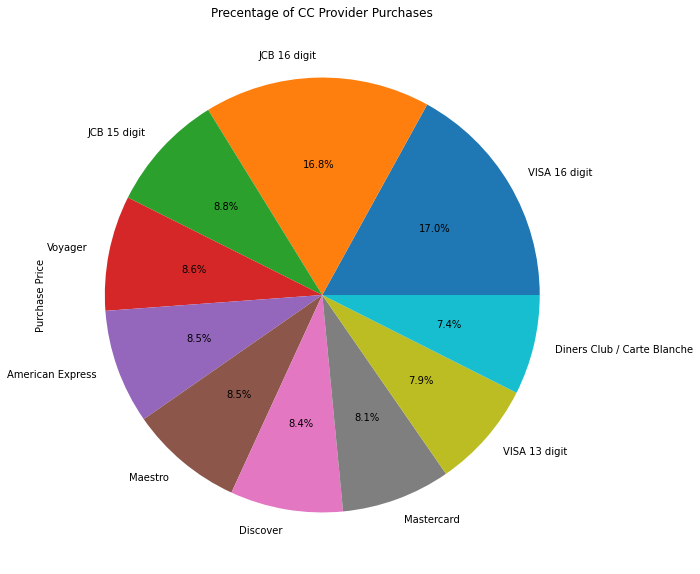

In [235]:
#% of purchases of CC Providers 
credit = pd_df.groupby('CC Provider')['Purchase Price'].sum().sort_values(ascending=False)
credit.plot(kind='pie', y='sum', autopct='%1.1f%%', figsize = (10,10), title = "Precentage of CC Provider Purchases")

Precentage of purchases per credit card.

Notice that the number of users does not guarantee that you have the most money spent. 

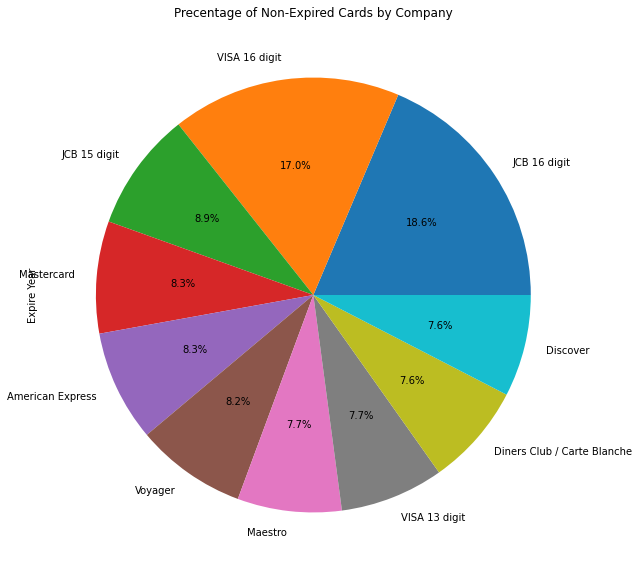

In [236]:
#Credit card info on years that have not expired yet
pd_df.loc[(pd_df['Expire Year']=='23')|(pd_df['Expire Year']=='24')|(pd_df['Expire Year']=='25')]\
  .groupby('CC Provider')['Expire Year']\
  .count().sort_values(ascending=False)\
  .plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), title = "Precentage of Non-Expired Cards by Company")

Precentage of non-expired credit cards.

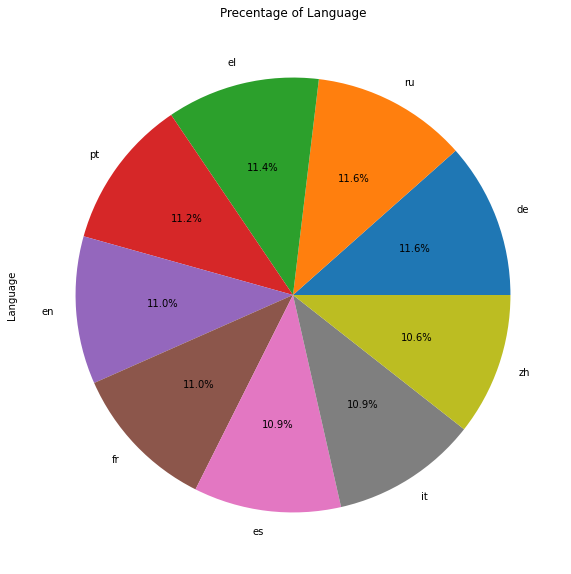

In [237]:
#Lang %
lang = pd_df.groupby('Language')['Language'].count().sort_values(ascending=False)
lang.plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), title = "Precentage of Language")

Precentage of language users.

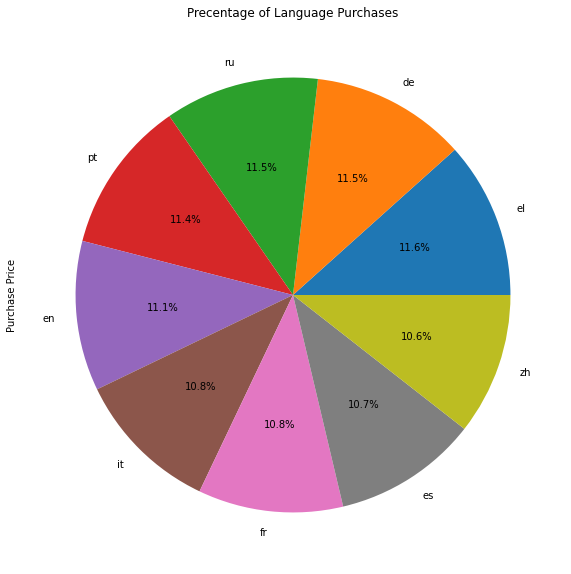

In [238]:
#lang % of purchases 
lang_pur = pd_df.groupby('Language')['Purchase Price'].sum().sort_values(ascending=False)
lang_pur.plot(kind='pie', y='sum', autopct='%1.1f%%', figsize = (10,10), title = "Precentage of Language Purchases")

Precentage of purchases per language.

Notice that el (Greek) is the third most used, but highest money spent.

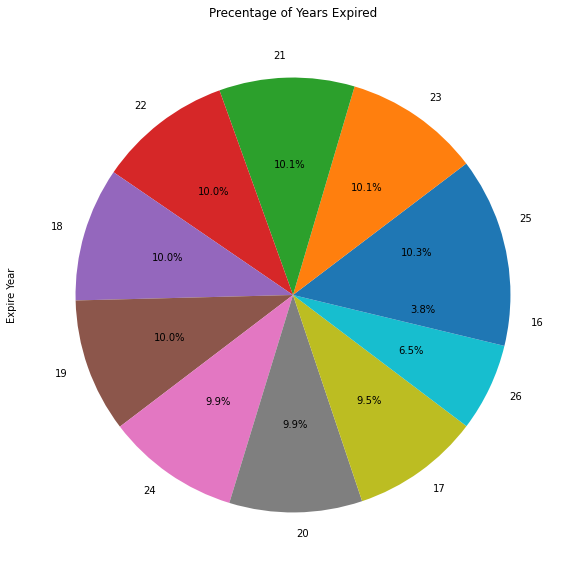

In [239]:
# % of cards expiring per year
year_expired = pd_df.groupby('Expire Year')['Expire Year'].count().sort_values(ascending=False)
year_expired.plot(kind='pie', y='sum', autopct='%1.1f%%', figsize = (10,10), 
                  title = "Precentage of Years Expired")

Precentage of years that cards expire. 

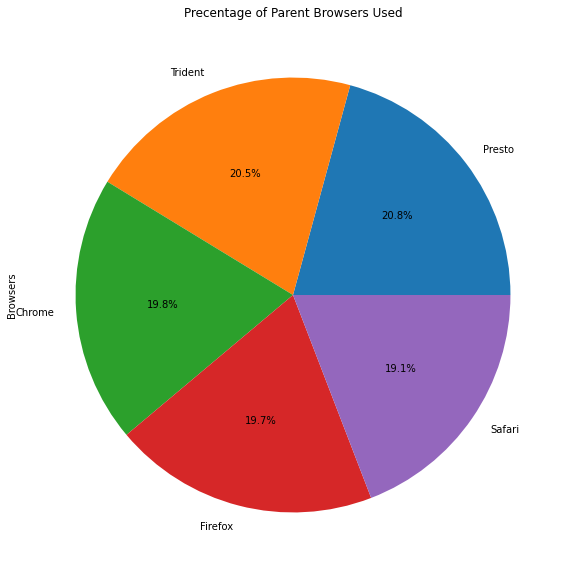

In [247]:
#% of browsers used 
pd_df.groupby('Browsers')['Browsers']\
  .count().sort_values(ascending=False)\
  .plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), 
        title = "Precentage of Parent Browsers Used")

Precentage of browsers used. 

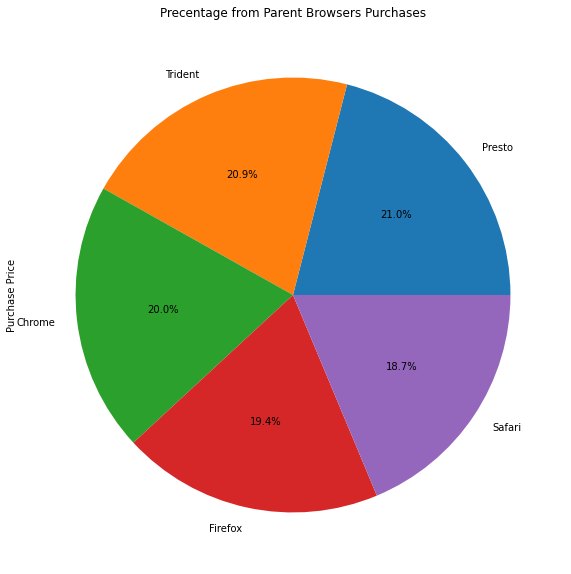

In [248]:
#% of Purchases by browser
pd_df.groupby('Browsers')['Purchase Price']\
  .sum().sort_values(ascending=False)\
  .plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10),
        title = "Precentage from Parent Browsers Purchases")

Precentage of purchases per browser.

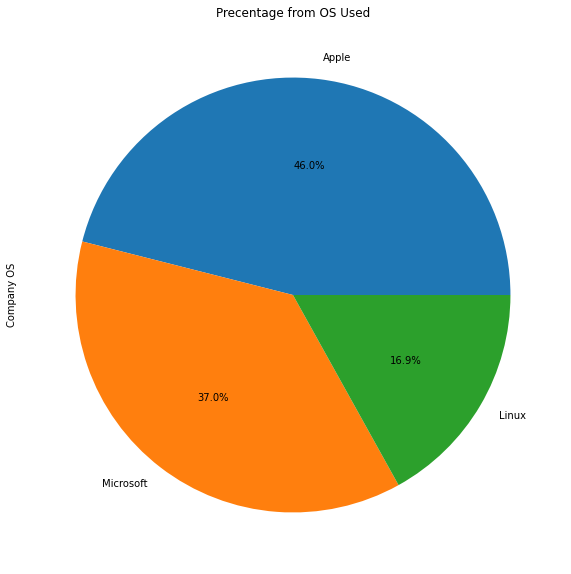

In [249]:
#% of OS used 
pd_df.groupby('Company OS')['Company OS']\
  .count().sort_values(ascending=False)\
  .plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), 
        title = "Precentage from OS Used")

Precentage of OS used.

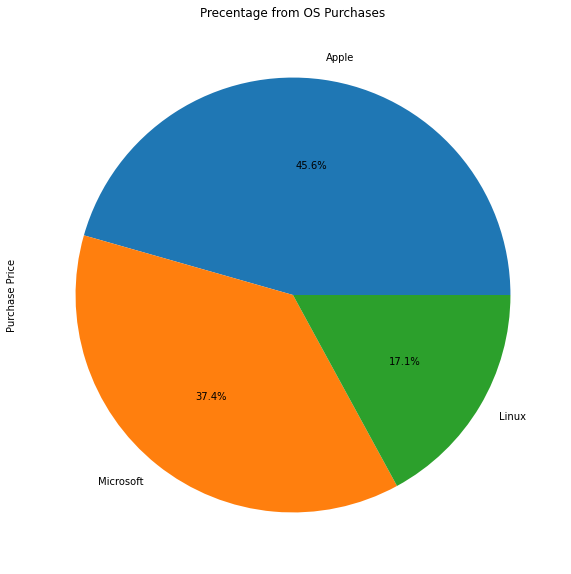

In [250]:
#% of Purchases by OS
pd_df.groupby('Company OS')['Purchase Price']\
  .sum().sort_values(ascending=False)\
  .plot(kind='pie', y='count', autopct='%1.1f%%', figsize = (10,10), 
        title = "Precentage from OS Purchases")

Precentage of purchases per OS used.